In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
import matplotlib.pyplot as plt
import math
import os.path
import time
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook 
from hmmlearn import hmm
import seaborn as sns
from sklearn.metrics import mean_squared_error

regimes = 4

In [2]:
### API
binance_api_key = '25HUOrJu76evPWNCJtSDydExaKtdB6DjyItVW5lTYSzEe2NgAvMsfLfuuX8Ake1m'  
binance_api_secret = 'vBaUNet4o7N2qVA3lW84Is6RXFnAt4Q6Dk6qdfiR1VzAOi0vO4Ujq2eCq0qHjCfP'

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def get_return(pre, post):
    return (post-pre)/pre

In [3]:
data = get_all_binance("XLMUSDT", "5m", save = True)

All caught up..!


In [4]:
close = np.array(data.iloc[:,3].astype(float), np.float)[-279564:]

In [5]:
obs = []
temp = []
values = []
for i in range(0, len(close)):
    temp.append(close[i])
    if len(temp) == 288:
        today = [get_return(temp[0], temp[-1]), mean_squared_error(temp, [sum(temp) / len(temp)] * len(temp))]
        values.append(temp[-1])
        obs.append(today)
        temp = []

training = obs[300:900]
test = obs[900:1100]

In [6]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = regimes, covariance_type="full", n_iter = 75);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

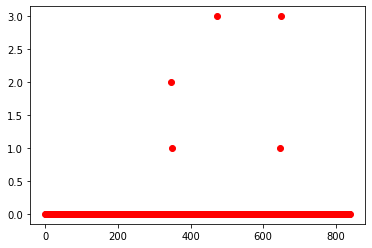

In [7]:
plt.plot(predictions, 'ro');

In [8]:
df = pd.DataFrame(data=values)
df = df.rename(columns={0: "values"})

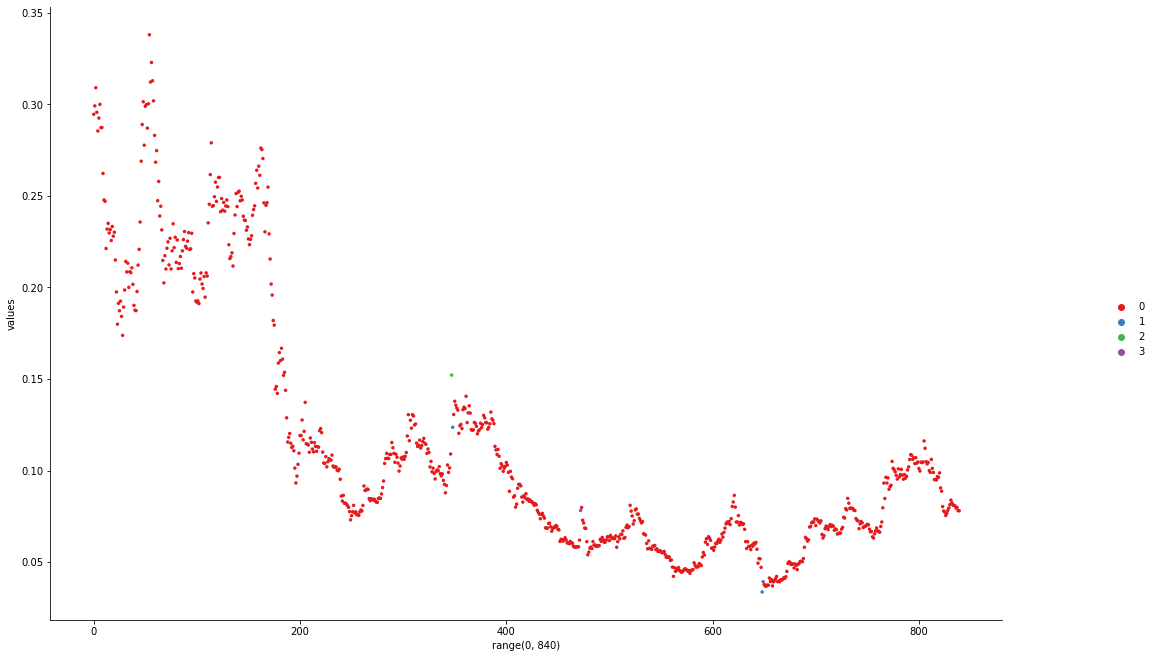

In [9]:
plot = sns.relplot(x=range(0, len(predictions)), y="values", data = df, hue=predictions, linewidth = 0, palette="Set1", s = 12);
plot.fig.set_size_inches(18,10)

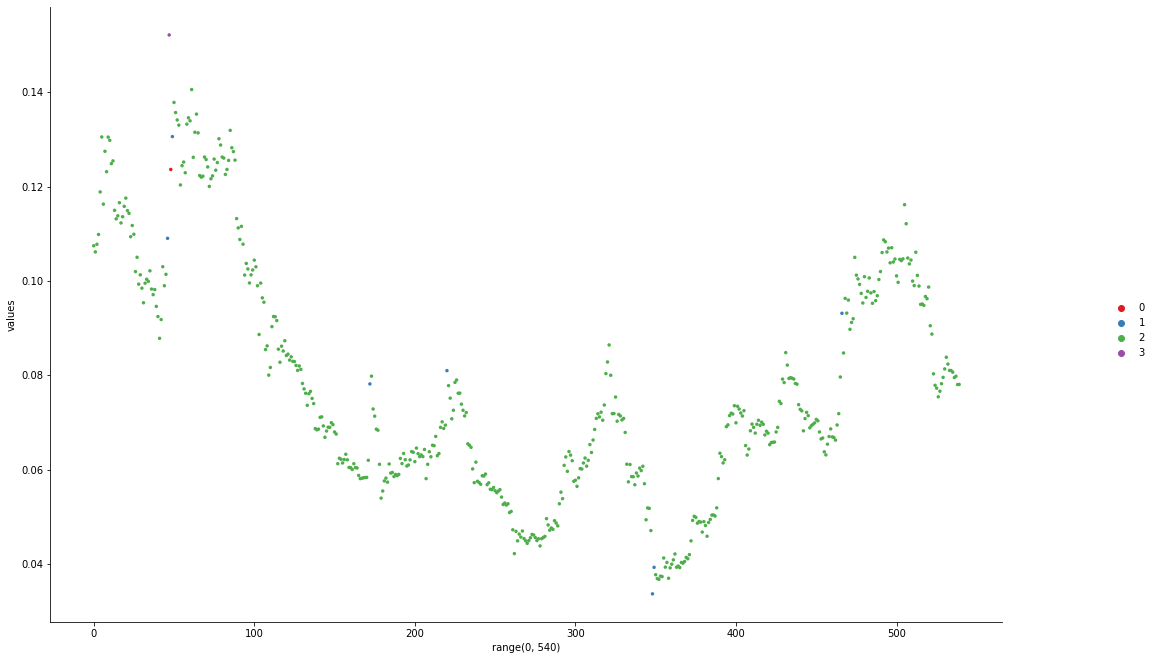

In [10]:
tdf = df.iloc[300:900, :]
training_obs = obs[300:900]
model = hmm.GaussianHMM(n_components = regimes, covariance_type="full", n_iter = 75);
model.fit(training_obs)
training_predictions = model.predict(training_obs)
plot = sns.relplot(x=range(0, len(training)), y="values", data = tdf, hue=training_predictions, linewidth = 0, palette="Set1", s = 12);
plot.fig.set_size_inches(18,10)

In [11]:
regime_count = {}
regime_returns = {}
regime_volatility = {}

for i in range(0, regimes):
    regime_returns[i] = 0
    regime_volatility[i] = 0
    regime_count[i] = 0
    
for i in range(0, len(training_predictions)):
    regime_count[training_predictions[i]] += 1
    
for i in range(0, len(training_obs)):
    regime_returns[training_predictions[i]] += training_obs[i][0]
    regime_volatility[training_predictions[i]] += training_obs[i][1]

for i in range(0, regimes):
    regime_returns[i] = regime_returns[i] / regime_count[i]
    regime_volatility[i] = regime_volatility[i] / regime_count[i]

In [12]:
for i in range(0, regimes):
    print("Regime " + str(i) + " return is " + str(regime_returns[i]))
    print("Regime " + str(i) + " volatility is " + str(regime_volatility[i]))

Regime 0 return is -0.1789438724676187
Regime 0 volatility is 6.070452754147377e-05
Regime 1 return is 0.08437171918031314
Regime 1 volatility is 2.4573959541377317e-05
Regime 2 return is -0.0008533362170526298
Regime 2 volatility is 1.984476409588989e-06
Regime 3 return is 0.4016400995116558
Regime 3 volatility is 0.00020795716368513694


In [13]:
model.transmat_

array([[2.60811834e-27, 9.95401858e-01, 4.59814247e-03, 1.51290748e-62],
       [1.95295201e-02, 1.70571943e-01, 7.08422697e-01, 1.01475840e-01],
       [6.51148690e-09, 1.31874980e-02, 9.86810391e-01, 2.10429832e-06],
       [9.95952640e-01, 4.04736035e-03, 5.64456860e-31, 0.00000000e+00]])

In [14]:
curr = training[:-100]
value = 100
position = 0
history = []
positions = []
size = len(test)
for i in range(0, size):
    if i != 0 and position == 1:
        value *= (0.999 + test[i][0])
    elif i != 0 and position == -1:
        value *= (0.999 - test[i][0])
    curr.append(test[i])
    forecast = model.predict(curr)[-1]
    if forecast == 0:
        position = 1
    elif forecast == 1:
        position = -1
    elif forecast == 2:
        position = 1
    elif forecast == 3:
        position = 0
    history.append(value)
    positions.append(position)

In [15]:
data = close[60000:]
arr = []
for i in range(0, len(data)):
    if i % 10 == 0:
        arr.append(data[i])
#Differencing
diff = []
for i in range(1, len(arr)):
    diff.append((arr[i] - arr[i-1]) / arr[i-1])
#MovingAverage
maf = pd.Series(diff).rolling(window=10).mean()
mas = pd.Series(diff).rolling(window=25).mean()

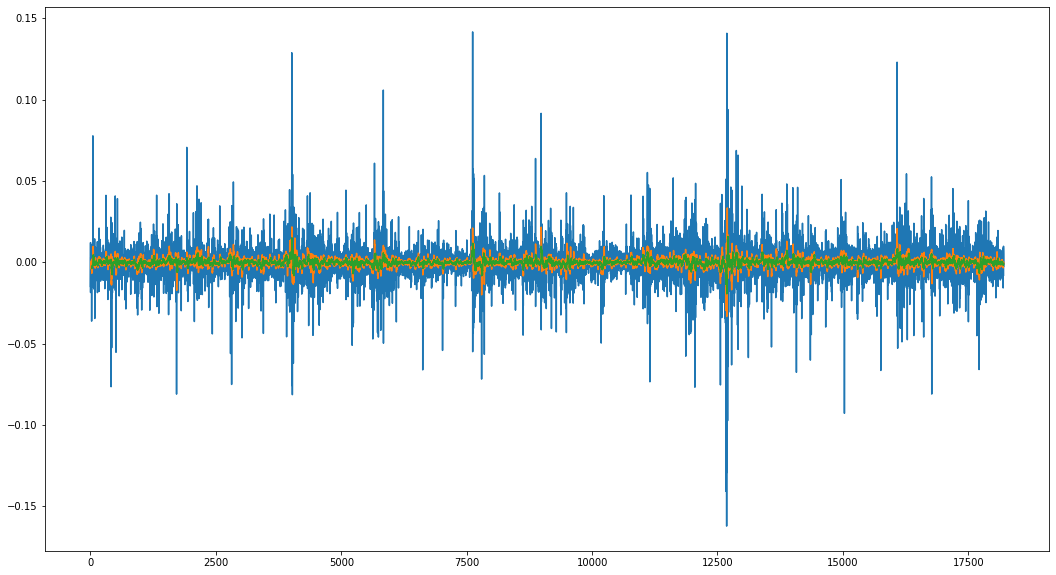

In [17]:
plt.figure(figsize=(18,10))
plt.plot(diff)
plt.plot(maf)
plt.plot(mas)

In [21]:
fastoverslow = True
long = []
short = []
for i in range(50, len(mas)):
    if maf[i] < mas[i]:
        if fastoverslow:
            short.append(diff[i])
        fastoverslow = False
    elif maf[i] > mas[i]:
        if not fastoverslow:
            long.append(diff[i])
        fastoverslow = True
 
        

(array([ 16., 427., 880., 120.,  23.,  10.,   3.,   1.,   1.,   1.]),
 array([-0.0261352 , -0.01293417,  0.00026685,  0.01346788,  0.02666891,
         0.03986994,  0.05307097,  0.06627199,  0.07947302,  0.09267405,
         0.10587508]),
 <a list of 10 Patch objects>)

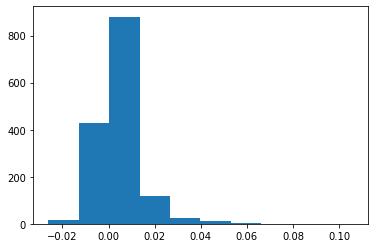

In [25]:
plt.hist(long)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 4.000e+00,
        1.900e+01, 1.130e+02, 1.216e+03, 1.240e+02]),
 array([-0.16212642, -0.14368984, -0.12525326, -0.10681669, -0.08838011,
        -0.06994353, -0.05150695, -0.03307037, -0.01463379,  0.00380278,
         0.02223936]),
 <a list of 10 Patch objects>)

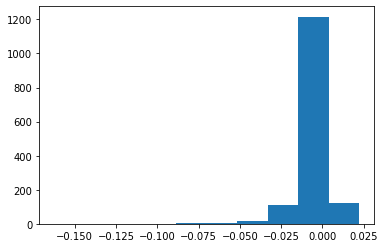

In [26]:
plt.hist(short)